# Implementing Soft-Actor-Critic V3  (no Value network)
(https://arxiv.org/abs/1812.05905)
### References: 
OpenAI Gym <br/>
https://github.com/ajaysub110/sac-pytorch

In [1]:
import simulation
import sys
import random
import pandas as pd
import importlib
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import torch.distributions as tdist
import torch.optim as opt
from collections import deque

In [2]:
TAU = 0.005
EPSILON = 1e-6
H_DIM = 32
LR = 3e-4
REPLAY_MEMORY_SIZE = 50000
ALPHA = 0.2
GAMMA = 0.99 # 0.98
ENTROPY_TUNING = True # True
MIN_LOG = -20
MAX_LOG = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#HElper
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        torch.nn.init.constant_(m.bias, 0)
def copy_params(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

def soft_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - TAU) + param.data * TAU)

In [4]:
class ReplayMemory:
    def __init__(self,size):
        self.size = size
        self.memory = deque([],maxlen=size)

    def push(self, x):
        self.memory.append(x)
    
    def sample(self, batch_size):
        if(batch_size <= self.get_len()):
            batch = random.sample(self.memory,batch_size)
            state, action, reward, next_state, done = map(np.stack, zip(*batch))
            return state, action, reward, next_state, done
        return None, None, None, None, None

    def get_len(self):
        return len(self.memory)

In [5]:
class Space():
    def __init__(self, low, high, length, dtype):
        self.shape = (length)
        self.dtype = np.dtype(dtype)
        self.low_bound = low
        self.high_bound = high
        self.low = np.ones(length)*low
        self.high = np.ones(length)*high

class ActionSpace(Space):
    def __init__(self, low = 0, high = 10, length=24, dtype= np.float32):
        super().__init__(low, high, length, dtype)
    
    def sample(self):
        return np.random.uniform(self.low_bound,self.high_bound,self.shape)

class StateSpace(Space):
    def __init__(self, low = 0, high = 100, length=48, dtype= np.float32):
        super().__init__(low, high, length, dtype)

class NormalizedActions(ActionSpace):
    def __init__(self):
        self.action_space = ActionSpace()
        self.state_space = StateSpace()
        
    def _action(self, action):
        """
        Input: Action- a np_array of length= self.length (self refers to NormalizedActions)
        Returns: "normalized action"
        """
        low  = self.low
        high = self.high
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.low
        high = self.high
        action_prime = []
        for x in np.nditer(action):
            x_prime = 2*(x-low) / (high-low) - 1
            action_prime.append(x_prime)
        action_prime = np.array(action_prime)
        action_prime = np.clip(action_prime, low, high)
        
        return action_prime
    
    def step(self, office, price, controllers_points):
        end = False
        energy_dict = {}
        rewards_dict = {}
        # DO per person reward!!
        # Add per person to parameter ^^^^
        # Add i to the state 
        # or add map i: kwh_i, or reference yesterday player energy
        count = 0
        energy = None
        for player_name in office.players_dict:
            if(count < 1):
                player = office.players_dict.get(player_name)
                player_energy = player.threshold_exp_response(controllers_points)
                energy = player_energy
                last_player_energy = player_energy
                energy_dict[player_name] = player_energy

                player_min_demand = player.get_min_demand()
                player_max_demand = player.get_max_demand()
                player_reward = simulation.Reward(player_energy, price[0:24], player_min_demand, player_max_demand)
                player_ideal_demands = player_reward.ideal_use_calculation()
                last_player_ideal = player_ideal_demands
                reward = player_reward.scaled_cost_distance_neg(player_ideal_demands)
                rewards_dict[player_name] = reward
                count += 1
        
        total_reward = sum(rewards_dict.values())
        office._timestep = office._timestep + office._time_interval
        
        if office._timestep>office._end_timestamp:
            office._timestep = office._start_timestamp

        #Traininng on one day!
        diff = (office.get_timestep()-office._start_timestamp)
        next_price = price[0:24] #office.price_signal(diff.days + 1)
        next_state = np.concatenate([next_price, energy])
        return next_state, total_reward, end

In [6]:
class QNetwork(nn.Module):
    def __init__(self,s_dim,a_dim,h_dim):
        super(QNetwork,self).__init__()

        self.linear1 = nn.Linear(s_dim+a_dim,h_dim)
        self.linear2 = nn.Linear(h_dim,h_dim)
        self.linear3 = nn.Linear(h_dim,1)

        self.apply(init_weights)

    def forward(self,s,a):
        x = torch.cat((s,a),dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x
        
class PolicyNetwork(nn.Module):
    def __init__(self,s_dim,a_dim,h_dim,action_space):
        super(PolicyNetwork,self).__init__()

        self.linear1 = nn.Linear(s_dim,h_dim)
        self.linear2 = nn.Linear(h_dim,h_dim)

        self.linear3a = nn.Linear(h_dim,a_dim)
        self.linear3b = nn.Linear(h_dim,a_dim)

        # Apply weight initialisation to all linear layers
        self.apply(init_weights)    

        # rescale actions
        if action_space is None:
            self.action_scale = torch.tensor(1.)
            self.action_bias = torch.tensor(0.)
        else:
            self.action_scale = torch.FloatTensor(
                (action_space.high - action_space.low) / 2.)
            self.action_bias = torch.FloatTensor(
                (action_space.high + action_space.low) / 2.)

    def forward(self,s):
        x = F.relu(self.linear1(s))
        x = F.relu(self.linear2(x))
        mean = self.linear3a(x)
        log_std = self.linear3b(x)

        # constrain log value in finite range to avoid NaN loss values
        log_std = torch.clamp(log_std, min=MIN_LOG, max=MAX_LOG)
        
        return mean, log_std

    def sample_action(self,s):
        mean, log_std = self.forward(s)
        std = log_std.exp()

        # calculate action using reparameterization trick and action scaling
        normal = Normal(mean, std)
        xi = normal.rsample()
        yi = torch.tanh(xi)
        a = yi * self.action_scale + self.action_bias
        log_pi = normal.log_prob(xi)

        # enforcing action bound (appendix of paper)
        log_pi -= torch.log(self.action_scale * (1 - yi.pow(2)) + EPSILON)
        log_pi = log_pi.sum(1,keepdim=True)
        mean = torch.tanh(mean)*self.action_scale + self.action_bias

        return a, log_pi, mean

In [7]:
class SoftActorCritic(object):
    def __init__(self,observation_space,action_space):
        self.s_dim = observation_space.shape
        self.a_dim = action_space.shape
        self.alpha = ALPHA

        # create component networks
        self.q_network_1 = QNetwork(self.s_dim,self.a_dim,H_DIM).to(device)
        self.q_network_2 = QNetwork(self.s_dim,self.a_dim,H_DIM).to(device)
        self.target_q_network_1 = QNetwork(self.s_dim,self.a_dim,H_DIM).to(device)
        self.target_q_network_2 = QNetwork(self.s_dim,self.a_dim,H_DIM).to(device)
        self.policy_network = PolicyNetwork(self.s_dim, self.a_dim, H_DIM, action_space).to(device)

        # copy weights from q networks to target networks
        copy_params(self.target_q_network_1, self.q_network_1)
        copy_params(self.target_q_network_2, self.q_network_2)
        
        # optimizers
        self.q_network_1_opt = opt.Adam(self.q_network_1.parameters(),LR)
        self.q_network_2_opt = opt.Adam(self.q_network_2.parameters(),LR)
        self.policy_network_opt = opt.Adam(self.policy_network.parameters(),LR)
        
        # automatic entropy tuning
        if ENTROPY_TUNING:
            self.target_entropy = -torch.prod(torch.Tensor(action_space.shape).to(device)).item()
            self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
            self.alpha_optim = opt.Adam([self.log_alpha], lr=LR)
                
        self.replay_memory = ReplayMemory(REPLAY_MEMORY_SIZE)

    def get_action(self, s):
        state = torch.FloatTensor(s).to(device).unsqueeze(0)
        action, _, _ = self.policy_network.sample_action(state)
        return action.detach().cpu().numpy()[0]

    def update_params(self, batch_size):
        states, actions, rewards, next_states, ndones = self.replay_memory.sample(batch_size)
        
        # make sure all are torch tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        ndones = torch.FloatTensor(np.float32(ndones)).unsqueeze(1).to(device)

        # compute targets
        with torch.no_grad():
            next_action, next_log_pi,_ = self.policy_network.sample_action(next_states)
            next_target_q1 = self.target_q_network_1(next_states,next_action)
            next_target_q2 = self.target_q_network_2(next_states,next_action)
            next_target_q = torch.min(next_target_q1,next_target_q2) - self.alpha*next_log_pi
            next_q = rewards + GAMMA*next_target_q

        # compute losses
        q1 = self.q_network_1(states,actions)
        q2 = self.q_network_2(states,actions)

        q1_loss = F.mse_loss(q1,next_q)
        q2_loss = F.mse_loss(q2,next_q)
        
        pi, log_pi,_ = self.policy_network.sample_action(states)
        q1_pi = self.q_network_1(states,pi)
        q2_pi = self.q_network_2(states,pi)
        min_q_pi = torch.min(q1_pi,q2_pi)

        policy_loss = ((self.alpha * log_pi) - min_q_pi).mean()

        # gradient descent
        self.q_network_1_opt.zero_grad()
        q1_loss.backward()
        self.q_network_1_opt.step()

        self.q_network_2_opt.zero_grad()
        q2_loss.backward()
        self.q_network_2_opt.step()

        self.policy_network_opt.zero_grad()
        policy_loss.backward()
        self.policy_network_opt.step()

        # alpha loss
        if ENTROPY_TUNING:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
            
            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()

            self.alpha = self.log_alpha.exp()
        else:
            alpha_loss = torch.tensor(0.).to(device)

        # update target network params
        soft_update(self.target_q_network_1,self.q_network_1)
        soft_update(self.target_q_network_2,self.q_network_2)

        return q1_loss.item(), q2_loss.item(), policy_loss.item(), alpha_loss.item()

In [12]:
env = NormalizedActions()
agent = SoftActorCritic(env.state_space, env.action_space)
replay_size = 100000
memory = ReplayMemory(replay_size)
agent.replay_memory = memory
total_numsteps = 2000
start_steps = 110
batch_size = 25
action_star = None
rewards = []
office = simulation.Office()
diff = (office.get_timestep()-office._start_timestamp)
state = np.concatenate([office.price_signal(diff.days + 50), np.zeros(24)])

for step in range(total_numsteps):
    print(str(step) + " / " + str(total_numsteps))
    if start_steps > step:
        action = env.action_space.sample()  # Sample random action
    else:
        action = agent.get_action(state)  # Sample action from policy
    
    next_state, reward, done = env.step(office, state, action)
    memory.push((state, action, reward, next_state, done))
    state = next_state
    action_star = action
    
    if(memory.get_len() > batch_size):
        critic_1_loss, critic_2_loss, policy_loss, alpha = agent.update_params(batch_size)
    
    rewards.append(reward)

rewards = [r[0] if r is np.ndarray else r for r in rewards]

creating agents
creating controller
0 / 2000
1 / 2000
2 / 2000
3 / 2000
4 / 2000
5 / 2000
6 / 2000
7 / 2000
8 / 2000
9 / 2000
10 / 2000
11 / 2000
12 / 2000
13 / 2000
14 / 2000
15 / 2000
16 / 2000
17 / 2000
18 / 2000
19 / 2000
20 / 2000
21 / 2000
22 / 2000
23 / 2000
24 / 2000
25 / 2000
26 / 2000
27 / 2000
28 / 2000
29 / 2000
30 / 2000
31 / 2000
32 / 2000
33 / 2000
34 / 2000
35 / 2000
36 / 2000
37 / 2000
38 / 2000
39 / 2000
40 / 2000
41 / 2000
42 / 2000
43 / 2000
44 / 2000
45 / 2000
46 / 2000
47 / 2000
48 / 2000
49 / 2000
50 / 2000
51 / 2000
52 / 2000
53 / 2000
54 / 2000
55 / 2000
56 / 2000
57 / 2000
58 / 2000
59 / 2000
60 / 2000
61 / 2000
62 / 2000
63 / 2000
64 / 2000
65 / 2000
66 / 2000
67 / 2000
68 / 2000
69 / 2000
70 / 2000
71 / 2000
72 / 2000
73 / 2000
74 / 2000
75 / 2000
76 / 2000
77 / 2000
78 / 2000
79 / 2000
80 / 2000
81 / 2000
82 / 2000
83 / 2000
84 / 2000
85 / 2000
86 / 2000
87 / 2000
88 / 2000
89 / 2000
90 / 2000
91 / 2000
92 / 2000
93 / 2000
94 / 2000
95 / 2000
96 / 2000
97 /

752 / 2000
753 / 2000
754 / 2000
755 / 2000
756 / 2000
757 / 2000
758 / 2000
759 / 2000
760 / 2000
761 / 2000
762 / 2000
763 / 2000
764 / 2000
765 / 2000
766 / 2000
767 / 2000
768 / 2000
769 / 2000
770 / 2000
771 / 2000
772 / 2000
773 / 2000
774 / 2000
775 / 2000
776 / 2000
777 / 2000
778 / 2000
779 / 2000
780 / 2000
781 / 2000
782 / 2000
783 / 2000
784 / 2000
785 / 2000
786 / 2000
787 / 2000
788 / 2000
789 / 2000
790 / 2000
791 / 2000
792 / 2000
793 / 2000
794 / 2000
795 / 2000
796 / 2000
797 / 2000
798 / 2000
799 / 2000
800 / 2000
801 / 2000
802 / 2000
803 / 2000
804 / 2000
805 / 2000
806 / 2000
807 / 2000
808 / 2000
809 / 2000
810 / 2000
811 / 2000
812 / 2000
813 / 2000
814 / 2000
815 / 2000
816 / 2000
817 / 2000
818 / 2000
819 / 2000
820 / 2000
821 / 2000
822 / 2000
823 / 2000
824 / 2000
825 / 2000
826 / 2000
827 / 2000
828 / 2000
829 / 2000
830 / 2000
831 / 2000
832 / 2000
833 / 2000
834 / 2000
835 / 2000
836 / 2000
837 / 2000
838 / 2000
839 / 2000
840 / 2000
841 / 2000
842 / 2000

1456 / 2000
1457 / 2000
1458 / 2000
1459 / 2000
1460 / 2000
1461 / 2000
1462 / 2000
1463 / 2000
1464 / 2000
1465 / 2000
1466 / 2000
1467 / 2000
1468 / 2000
1469 / 2000
1470 / 2000
1471 / 2000
1472 / 2000
1473 / 2000
1474 / 2000
1475 / 2000
1476 / 2000
1477 / 2000
1478 / 2000
1479 / 2000
1480 / 2000
1481 / 2000
1482 / 2000
1483 / 2000
1484 / 2000
1485 / 2000
1486 / 2000
1487 / 2000
1488 / 2000
1489 / 2000
1490 / 2000
1491 / 2000
1492 / 2000
1493 / 2000
1494 / 2000
1495 / 2000
1496 / 2000
1497 / 2000
1498 / 2000
1499 / 2000
1500 / 2000
1501 / 2000
1502 / 2000
1503 / 2000
1504 / 2000
1505 / 2000
1506 / 2000
1507 / 2000
1508 / 2000
1509 / 2000
1510 / 2000
1511 / 2000
1512 / 2000
1513 / 2000
1514 / 2000
1515 / 2000
1516 / 2000
1517 / 2000
1518 / 2000
1519 / 2000
1520 / 2000
1521 / 2000
1522 / 2000
1523 / 2000
1524 / 2000
1525 / 2000
1526 / 2000
1527 / 2000
1528 / 2000
1529 / 2000
1530 / 2000
1531 / 2000
1532 / 2000
1533 / 2000
1534 / 2000
1535 / 2000
1536 / 2000
1537 / 2000
1538 / 2000
1539

Text(0.5, 1.0, 'Rewards (SAC V3)')

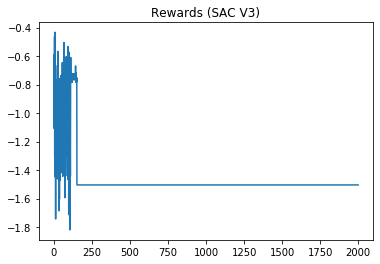

In [16]:
plt.plot(np.array(range(total_numsteps)),rewards)
plt.title("Rewards (SAC V3)")

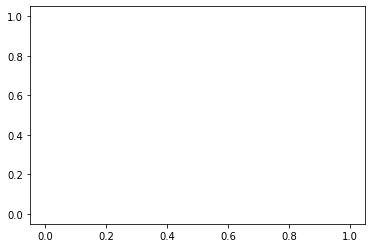

In [17]:
plt.plot(np.array(range(24)),action_star)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
----
[nan nan nan nan nan nan nan nan nan]


Text(0.5, 1.0, 'Price of Energy Today (SAC V3)')

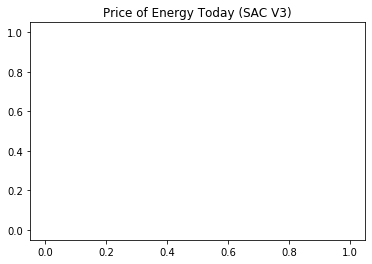

In [18]:
action_prime = action_star[8:17]
print(action_star)
print("----")
print(action_prime)
plt.plot(np.array([i for i in range(9,18)]),np.array(action_prime))
plt.title("Price of Energy Today (SAC V3)")